In [1]:
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
import pymc3 as pm

In [2]:
figsize(12.5, 3.5)
continuous_data = np.loadtxt("example_data/continuous_data.csv")
n_continuous_data = len(continuous_data)

Text(0.5, 1.0, 'Did the exposed outperform the control over time?')

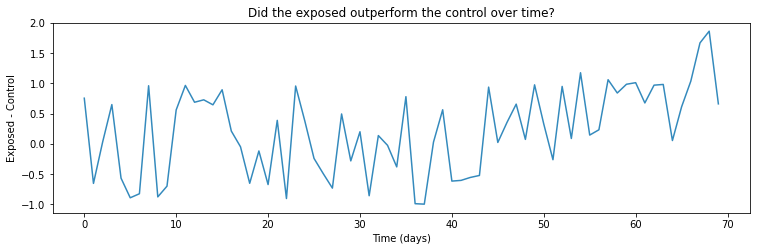

In [3]:
days = np.arange(0, n_continuous_data)
plt.plot(days, continuous_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("Exposed - Control")
plt.title("Did the exposed outperform the control over time?")

In [4]:
alpha = 1.0
basic_model = pm.Model()
with basic_model:
    # Priors for unknown model parameters
    sigma_before = pm.Exponential("sigma_before", alpha)
    sigma_after = pm.Exponential("sigma_after", alpha)
    mu_before = pm.Normal('mu_before', mu=0, sigma=1)
    mu_after = pm.Normal('mu_after', mu=0, sigma=1)
    when_changed = pm.DiscreteUniform("when_changed", lower=0, upper=n_continuous_data)
    mu = pm.math.switch(when_changed >= days, mu_before, mu_after)
    sigma = pm.math.switch(when_changed >= days, sigma_before, sigma_after)
    # Likelihood (sampling distribution) of observations
    observation = pm.Normal("observation", mu=mu, sigma=sigma, observed=continuous_data)

In [5]:
with basic_model:
    trace = pm.sample(10000, return_inferencedata=False)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu_after, mu_before, sigma_after, sigma_before]
>Metropolis: [when_changed]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
The number of effective samples is smaller than 10% for some parameters.


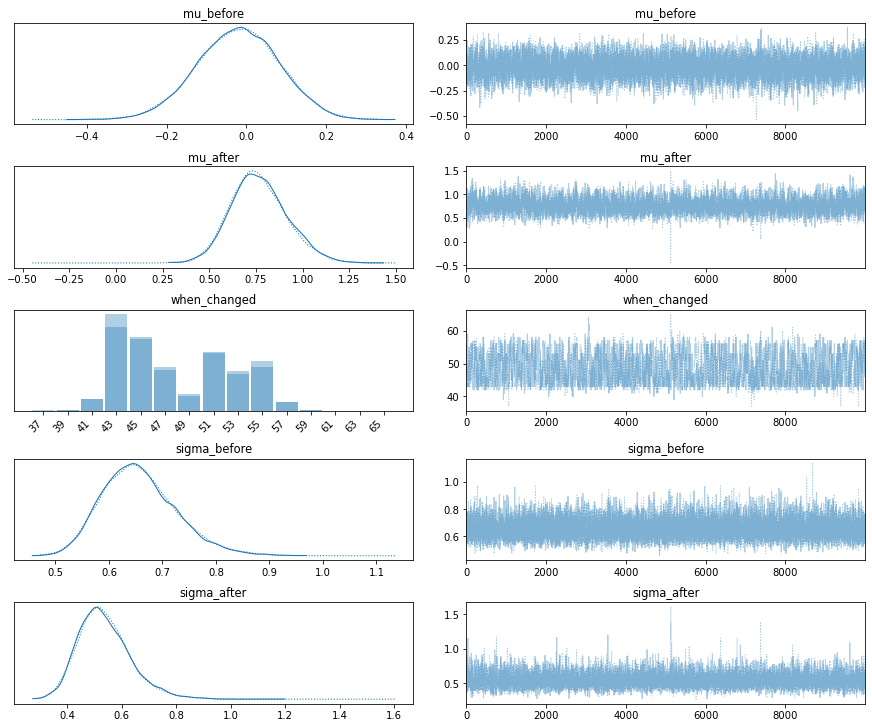

In [6]:
with basic_model:
    axes_arr = az.plot_trace(trace)
plt.draw()
for ax in axes_arr.flatten():
    if ax.get_title() == "when_changed":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=45, ha="right")
        break
plt.draw()

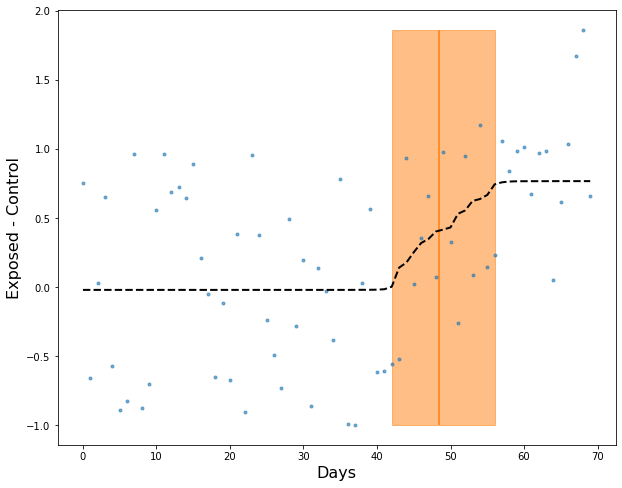

In [7]:
plt.figure(figsize=(10, 8))
plt.plot(days, continuous_data, ".", alpha=0.6)
plt.ylabel("Exposed - Control", fontsize=16)
plt.xlabel("Days", fontsize=16)

plt.vlines(trace["when_changed"].mean(), continuous_data.min(), continuous_data.max(), color="C1")
average_change = np.zeros_like(continuous_data, dtype="float")
for i, day in enumerate(days):
    idx = day < trace["when_changed"]
    average_change[i] = np.mean(np.where(idx, trace["mu_before"], trace["mu_after"]))

sp_hpd = az.hdi(trace["when_changed"])
plt.fill_betweenx(
    y=[continuous_data.min(), continuous_data.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(days, average_change, "k--", lw=2);

In [8]:
(trace["mu_before"] < trace["mu_after"]).mean()

0.99985